In [1]:
from __future__ import (division, print_function,
                        unicode_literals, absolute_import)

import numpy as np
import scipy.integrate
import scipy.stats
import matplotlib.pyplot as plt

%matplotlib inline

# Bayesian Statistics for Data Analysis

## Paul T. Baker

Some resourses I like:

 * [Allen B Downey, *Think Bayes: Bayesian Statistics Made Simple*, Green Tea Press (2012)](http://greenteapress.com/wp/think-bayes/)
 * Phil Gregory, *Bayesian Logical Data Analysis for the Physical Sciences: A Comparative Approach*, Cambridge University Press (2010)
 * William M. Bolstad, *Understanding Computational Bayesian Statistics*, Wiley (2009)

## Example: fitting a spectral line

We have some noisy data containing a possible novel spectral line feature.  The spectrum is measured as a temperature anomaly, $dT_i$ in each frequency channel $\nu_i$ (relative to the mean observed temperature).

Some theory predicts the line will have a gaussian shape:

$$dT_i = T_0 \exp\left( \frac{-(\nu_i-\nu_0)^2}{2{\sigma_L}^2} \right),$$

where $T_0$ is the amplitude of the feature, that according to the theory can range from 0.01-100 mK.  The frequency of a channel $\nu_i$ is recorded as the channel number for our instrument, and the theory says line should appear in channel $\nu_0=37$ with width $\sigma_L=2$.

Our instrument has white radiometer noise at a level of $\sigma=1$ mK.

<sub>This problem is adapted from an example used in chapter 3 of Gregory (2010).</sub>

## simulate data

$$d_i = dT_i + n_i$$

Let's simulate data with a line that has an amplitude of $T_0 = 1.5$ mK.

In [2]:
def line_model(v, T0=1.5, v0=37, sigL=2):
    """compute dT for frequencies, v"""
    v = np.asarray(v)
    arg = (0.5*(v-v0)/sigL)**2
    return T0 * np.exp(-arg)

Tin = 1.5  # T input
sigN = 1  # noise stdev

N = 64  # number of channels
freq = np.arange(N)
line = line_model(freq, T0=Tin)
noise = np.random.normal(loc=0, scale=sigN, size=N)
data = line + noise

In [3]:
data = np.loadtxt("spec_quiet.dat")
#np.savetxt("spec_quiet.dat", data)

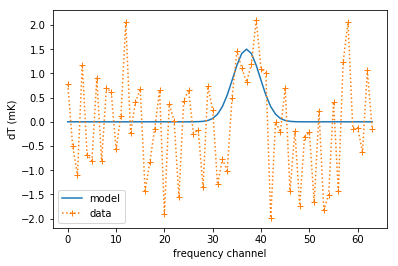

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(freq, line, label='model')
ax.plot(freq, data, marker='+', linestyle=':', label='data')
ax.set_ylabel('dT (mK)')
ax.set_xlabel('frequency channel')
ax.legend()
fig.savefig('spect.pdf')

## calculate likelihood for noise only
$$p\left(d \mid \mathcal{H}_0 \right) = \left(\frac{1}{\sqrt{2\pi}\,\sigma}\right)^N \exp\left(- \frac{{d_i}^2}{2{\sigma}^2}\right)$$

In [5]:
norm = (np.sqrt(2*np.pi)*sigN)**-N
arg = 0.5*np.sum(data**2)/sigN**2
pdH0 = norm * np.exp(-arg)
print(pdH0)

5.32328024596e-41


## calculate likelihood for line model

### marginalize over nuisance param $T$
$$p\left(d \mid \mathcal{H}_1 \right) = \int \mathrm{d}T \, p\left(T \mid \mathcal{H}_1 \right)\, p\left( d \mid \mathcal{H}_1, T \right)$$

### we will work with $\log T$ since we don't have any scale information
$$p\left(d \mid \mathcal{H}_1 \right) = \int \mathrm{d}\log T \, p\left(\log T \mid \mathcal{H}_1 \right)\, p\left( d \mid \mathcal{H}_1, \log T \right)$$

for this $\log = \log_{10}$

### assume a uniform prior on $\log T$ (log-uniform on $T$)
$$p\left(\log T \mid \mathcal{H}_1 \right) = \frac{1}{\Delta \log T}$$

### likelihood as function of $\log T$
modeled line:
$$m_i = dT_i = 10^{\log T} \, \exp\left(- \frac{{\nu_i-\nu_0}^2}{2{\sigma_L}^2}\right)$$

Gaussian likelihood for residuals
$$ p\left( d \mid \mathcal{H}_1, \log T \right) = \left(\frac{1}{\sqrt{2\pi}\,\sigma}\right)^2 \exp\left(- \frac{{(d_i-m_i)}^2}{2{\sigma}^2}\right)$$

In [6]:
logTmin = -2  # 0.01
logTmax = +2  # 100
dlogT = logTmax - logTmin

def integrand(logT):
    """calculate integrand for given T"""
    pTH1 = 1/dlogT
    
    model = line_model(freq, T0=10**logT, v0=37, sigL=2)
    
    norm = (np.sqrt(2*np.pi)*sigN)**-N
    resid = data-model
    arg = 0.5*np.sum(resid**2)/sigN**2
    pdH1T = norm * np.exp(-arg)
    
    return pdH1T * pTH1

logTs = np.linspace(logTmin, logTmax, 1000)  # 1000 pts
pdH1T_dat = np.array([integrand(logT) for logT in logTs])  # integrand data

pdH1 = scipy.integrate.simps(pdH1T_dat, logTs)  # simpson's integrater!
print(pdH1)

2.43126375532e-40


## Odds ratio

$$\mathcal{O}_{1,0} = \frac{p\left(d\mid\mathcal{H}_1\right)}{p\left(d\mid\mathcal{H}_0\right)}$$

In [7]:
O = pdH1 / pdH0
prob = 1-1/O
print("odds ratio = {:2f};  prob = {:4f}".format(O, prob))

odds ratio = 4.567229;  prob = 0.781049


using **max**-$\mathcal{L}$ instead of **marginal**-$\mathcal{L}$ is wrong!

does not account for **occam factor**, extra degrees of freedom in line model

In [8]:
maxL = np.max(pdH1T_dat)
L_ratio = maxL/pdH0
prob_wrong = 1-1/L_ratio
print("L ratio = {:2f};  prob = {:4f}".format(L_ratio, prob_wrong))

L ratio = 8.606614;  prob = 0.883810


## Parameter estimation

To determine the best fit params we will need the PDF and the CDF of $T$.

These can be approximated by hand, but `scipy.stats` provides some nice functions to create an `RV` (random variate) object from a histogram (which we already have from the numerical integral)

In [9]:
PDF_hist = pdH1T_dat/pdH1  # normalized!
PDF_bins = np.hstack([[0], 10**logTs])
T_rv = scipy.stats.rv_histogram([PDF_hist, PDF_bins])

now we can plot the PDF and CDF for any range of $T$'s we want!

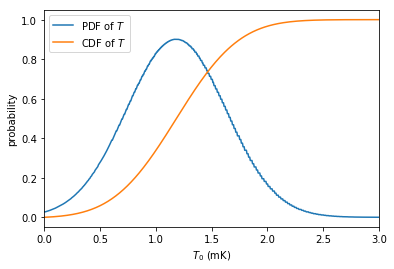

In [10]:
Ts = np.linspace(0, 5, 1000)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(Ts, T_rv.pdf(Ts), label=r'PDF of $T$')
ax.plot(Ts, T_rv.cdf(Ts), label=r'CDF of $T$')
ax.set_ylabel('probability')
ax.set_xlabel(r'$T_0$ (mK)')
ax.set_xlim([0,3])
ax.legend()
fig.savefig('T_DFs.pdf')

The RV object provides nice functions to compute the median and **credible intervals**.

In [11]:
T_med = T_rv.median()
T_90 = T_rv.interval(.90)
print("T = {0:.2f}, 1-sigma CI = ({1:.2f} - {2:.2f})".format(T_med,*T_90))

T = 1.18, 1-sigma CI = (0.47 - 1.91)


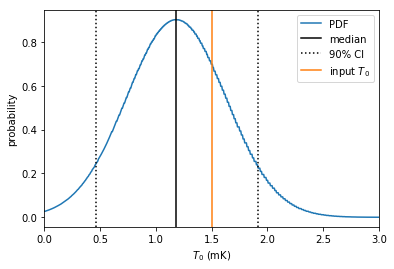

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(Ts, T_rv.pdf(Ts), label='PDF')
ax.axvline(x=T_med, color = 'k', label='median')
ax.axvline(x=T_90[0], color = 'k', linestyle=':', label=r'90% CI')
ax.axvline(x=T_90[1], color = 'k', linestyle=':')
ax.axvline(x=Tin, color = 'C1', label='input $T_0$')
ax.set_ylabel('probability')
ax.set_xlabel(r'$T_0$ (mK)')
ax.legend()
#ax.set_xscale('log')
ax.set_xlim([0,3])
fig.savefig('T_PE.pdf')